In [1]:
# Import the libraries
import pandas as pd
import numpy as np
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from datetime import datetime, timedelta

from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import roc_curve, confusion_matrix, accuracy_score, classification_report, roc_auc_score, f1_score, precision_score, recall_score
from plot_metric.functions import BinaryClassification
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.preprocessing import PowerTransformer

pd.options.display.max_rows = 200

def Find_Optimal_Cutoff(target, predicted):
    '''Find data-driven cut-off for classification
    
    Cut-off is determined using Youden's index defined as sensitivity + specificity - 1.
    
    Parameters
    ----------
    target : array, shape = [n_samples]
        True binary labels.
        
    predicted : array, shape = [n_samples]
        Target scores, can either be probability estimates of the positive class,
        confidence values, or non-thresholded measure of decisions (as returned by
        “decision_function” on some classifiers).
        
    References
    ----------
    Ewald, B. (2006). Post hoc choice of cut points introduced bias to diagnostic research.
    Journal of clinical epidemiology, 59(8), 798-801.
    
    Steyerberg, E.W., Van Calster, B., & Pencina, M.J. (2011). Performance measures for
    prediction models and markers: evaluation of predictions and classifications.
    Revista Espanola de Cardiologia (English Edition), 64(9), 788-794.
    
    Jiménez-Valverde, A., & Lobo, J.M. (2007). Threshold criteria for conversion of probability
    of species presence to either–or presence–absence. Acta oecologica, 31(3), 361-369.
    '''
    fpr, tpr, thresholds = roc_curve(target, predicted)
    idx = np.argmax(tpr - fpr)
    return thresholds[idx]

def train_model(data_final):
    feature_list_for_training = [
        'sex_M',
        'age',
        'substance',
        'mood',
        'anxiety',
        'psychotic',
        'cognitive',
        'otherpsych',
        'selfharm',
        'visit_emr_MH_non_elect',
        'visit_emr_NonMH',
        'visit_emr_visit',
        'visit_hosp_visit',
        'visit_hospitalized_MH',
        'visit_hospitalized_NonMH',
        'visit_family_gp',
        'visit_im',
        'visit_neurology',
        'visit_other',
        'visit_psychiatry',
        'EX_CHF',
        'EX_Arrhy',
        'EX_VD',
        'EX_PCD',
        'EX_PVD',
        'EX_HPTN_UC',
        'EX_HPTN_C',
        'EX_Para',
        'Ex_OthND',
        'Ex_COPD',
        'Ex_Diab_UC',
        'Ex_Diab_C',
        'Ex_Hptothy',
        'Ex_RF',
        'Ex_LD',
        'Ex_PUD_NB',
        'Ex_HIV',
        'Ex_Lymp',
        'Ex_METS',
        'Ex_Tumor',
        'Ex_Rheum_A',
        'Ex_Coag',
        'Ex_Obesity',
        'Ex_WL',
        'Ex_Fluid',
        'Ex_BLA',
        'Ex_DA',
        'Ex_Alcohol',
        'Ex_Drug',
        'Ex_Psycho',
        'Ex_Dep',
        'Ex_Stroke',
        'Ex_Dyslipid',
        'Ex_Sleep',
        'Ex_IHD',
        'EX_Fall',
        'EX_Urinary',
        'EX_Visual',
        'EX_Hearing',
        'EX_Tobacco',
        'EX_Delirium',
        'Ex_MS',
        'EX_parkinsons',
    ]

    # Separate the features for training
    X = data_final[feature_list_for_training]

    # Separate the labels for the training
    y = data_final['homeless_followup']

    # Normalization
    scaler_PT = PowerTransformer()
    X = pd.DataFrame(scaler_PT.fit_transform(X), columns=X.columns)

    # Add the constant to the X features
    X = sm.add_constant(X)

    # Split the dataset into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

    # Only oversample for the train sets to balance the classes
    over_sampler = RandomOverSampler(random_state=42)
    X_train, y_train = over_sampler.fit_resample(X_train, y_train)

    print("### Classes percentage in the training as there are no longer any imbalances:")
    print(y_train.value_counts() * 100 / len(y_train))

    # Fit the model
    log_reg = sm.Logit(y_train, X_train).fit()

    # After fitting the model, we need to test the model on the X_test (yhat are the predicted probabilities)
    yhat = log_reg.predict(X_test)

    # Find optimal probability threshold by using yhat as a continuous measure
    threshold = Find_Optimal_Cutoff(y_test, yhat)

    # Find prediction to the DataFrame applying threshold:
    # Choose the cutoff so that the outcome is more balanced, using either the Youden index
    prediction = pd.Series(yhat).map(lambda x: 1 if x > threshold else 0)

    # Calculate evaluation metrics
    f1 = f1_score(y_test, prediction)
    roc_auc = roc_auc_score(y_test, prediction)
    sensitivity = recall_score(y_test, prediction)
    precision = precision_score(y_test, prediction)

    # Create a DataFrame to store the results
    df_results = pd.DataFrame((round(f1, 2), round(roc_auc, 2), round(sensitivity, 2), round(precision, 2)))
    df_results = df_results.T

    return (df_results, X_train, X_test, y_train, y_test, prediction, log_reg, feature_list_for_training, y)

# Read the data into a DataFrame
data_final = pd.read_hdf('data/df_subjects_retro_homelss.h5', 'df_subjects_retro_homelss')

# Fill missing values in the 'homeless_followup' column with 0
data_final.homeless_followup = data_final.homeless_followup.fillna(0)

# Map non-zero values to 1 in the 'homeless_followup' column
data_final['homeless_followup'] = data_final['homeless_followup'].map(lambda x: 0 if x == 0 else 1)

# Filter the data where 'homeless_followup' is 1
data_final[data_final['homeless_followup'] == 1]

# Create dummy variables for the 'sex' column
data_final = data_final.join(pd.get_dummies(data_final['sex'], prefix='sex'))

# Categorize age into age groups
data_final['age_categorical'] = data_final['age'].map(lambda x: '18-29' if ((x >= 18) and (x < 30)) else ('30-39' if ((x >= 30) and (x < 40)) else ('40-49' if ((x >= 40) and (x < 50)) else ('50-59' if ((x >= 50) and (x < 60)) else ('60+' if x >= 60 else '')))))

# Create dummy variables for the age groups
data_final = data_final.join(pd.get_dummies(data_final['age_categorical'], prefix='age'))

print(data_final.shape)

# Train the model
df_results, X_train, X_test, y_train, y_test, prediction, log_reg, feature_list_for_training, y = train_model(data_final)


/Users/fuzzysha/software/miniconda3/envs/hproj/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/fuzzysha/software/miniconda3/envs/hproj/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


(237602, 90)


/Users/fuzzysha/software/miniconda3/envs/hproj/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


### Classes percentage in the training as there are no longer any imbalanceness:
0    50.0
1    50.0
Name: homeless_followup, dtype: float64
Optimization terminated successfully.
         Current function value: 0.359692
         Iterations 7


# The results for normalized and balanced classes 

Confusion Matrix : 
 [[19706  3890]
 [   24   141]]
Test accuracy =  0.8352762930853078
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     23596
           1       0.03      0.85      0.07       165

    accuracy                           0.84     23761
   macro avg       0.52      0.84      0.49     23761
weighted avg       0.99      0.84      0.90     23761

F1 Score: 0.06720686367969494
AUC: 0.84%


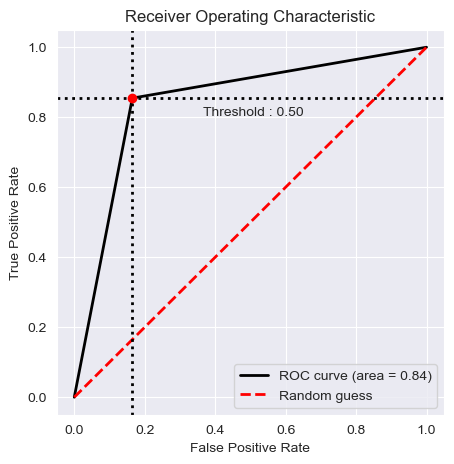

In [2]:

# Confusion matrix
cm = confusion_matrix(y_test, prediction)
print("Confusion Matrix:\n", cm)

# Accuracy score of the model
print('Test accuracy =', accuracy_score(y_test, prediction))

# Classification report
print(classification_report(y_test, prediction))

# F1 Score
print("F1 Score:", f1_score(y_test, prediction))

# Calculate ROC AUC
roc_auc = roc_auc_score(y_test, prediction)
print('AUC: %.2f' % roc_auc + "%")

# Visualisation with plot_metric
# Create a BinaryClassification object with true labels (y_test) and predicted labels (prediction)
bc = BinaryClassification(y_test, prediction, labels=["Class 1", "Class 2"])

# Plot ROC curve
plt.figure(figsize=(5, 5))
bc.plot_roc_curve()
plt.show()


In [3]:
#save the dataframe to a hdf file
data_final.to_hdf('retro_ARC_Homelessness_training/data/retro_data_final_homlessness.h5', 'retro_data_final_homlessness')

/var/folders/8k/v_790m6j3ksgsl4j86kmxvsw0000gn/T/ipykernel_38518/3156679379.py:1: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->Index(['subject_id', 'sex', 'quintmat', 'quintsoc', 'age_categorical'], dtype='object')]

  data_final.to_hdf('retro_ARC_Homelessness_training/data/retro_data_final_homlessness.h5', 'retro_data_final_homlessness')
